# estimate $p(\theta_{\rm cosmo}\,|\,X, m_{\rm SPS})$ using a normalizing flow

More specifically, we'll be estimating 
$$p(\Omega_m, \sigma_8, A_{\rm SN1}, A_{\rm AGN1}, A_{\rm SN2}, A_{\rm AGN2} | M_g, M_r, M_i, M_z, \sigma_g, \sigma_r, \sigma_i, \sigma_z)$$
assuming the SPS model that TNG uses to forward model the photometry

In [1]:
import os
import h5py 
import numpy as np

In [2]:
import copy
import torch
import torch.optim as optim
from sbi import utils as Ut
from sbi import inference as Inference

In [3]:
import corner as DFM
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
seed = 12387
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

## load CAMELS data set

In [6]:
dat_dir = '/tigress/chhahn/cgpop/'
data = np.loadtxt(os.path.join(dat_dir, 'camels_tng.omega_x.down.dat'), skiprows=1, unpack=True)

data_omega = data.T.astype(np.float32)[:,:6]       # cosmological and hydrodynamical parameters
data_photo = data.T.astype(np.float32)[:,6:]     # measured photometry and noise

In [7]:
# Om, s8, Asn1, Aagn1, Asn2, Aagn2, Mg, Mstar, Mbh, Mtot, Vmax, Vdisp, Zg, Zs, SFR, J, Vel, Rstar, Rtot, Rvmax,
# absmag U, B, V, K, g, r, i, z
lbls = [r'$\Omega_m$', r'$\sigma_8$', 
        r'$\log A_{\rm SN1}$', r'$\log A_{\rm AGN1}$', r'$\log A_{\rm SN2}$', r'$\log A_{\rm AGN2}$', 
        r'$\log M_g$', r'$\log M_*$', r'$M_{\rm BH}$', r'$M_{\rm tot}$', r'$V_{\rm max}$', r'$V_{\rm disp}$', 
        r'$Z_g$', r'$\log Z_*$', 'SFR', 'J', 'V', r'$\log R_*$', r'$R_{\rm tot}$', r'$R_{\rm vmax}$', 
        r'$U$ absmag', r'$B$ absmag', r'$V$ absmag', r'$K$ absmag', r'$g$ absmag', r'$r$ absmag', r'$i$ absmag', 
        r'$z$ absmag']

In [8]:
icosmo = [0, 1, 2, 3, 4, 5] # cosmological/hydro parameters
iobs = [-4, -3, -2, -1]

# $p(\Omega_m, \sigma_8, A_{\rm SN1}, A_{\rm AGN1}, A_{\rm SN2}, A_{\rm AGN2}, M_g, M_r, M_i, M_z, \sigma_g, \sigma_r, \sigma_i, \sigma_z)$


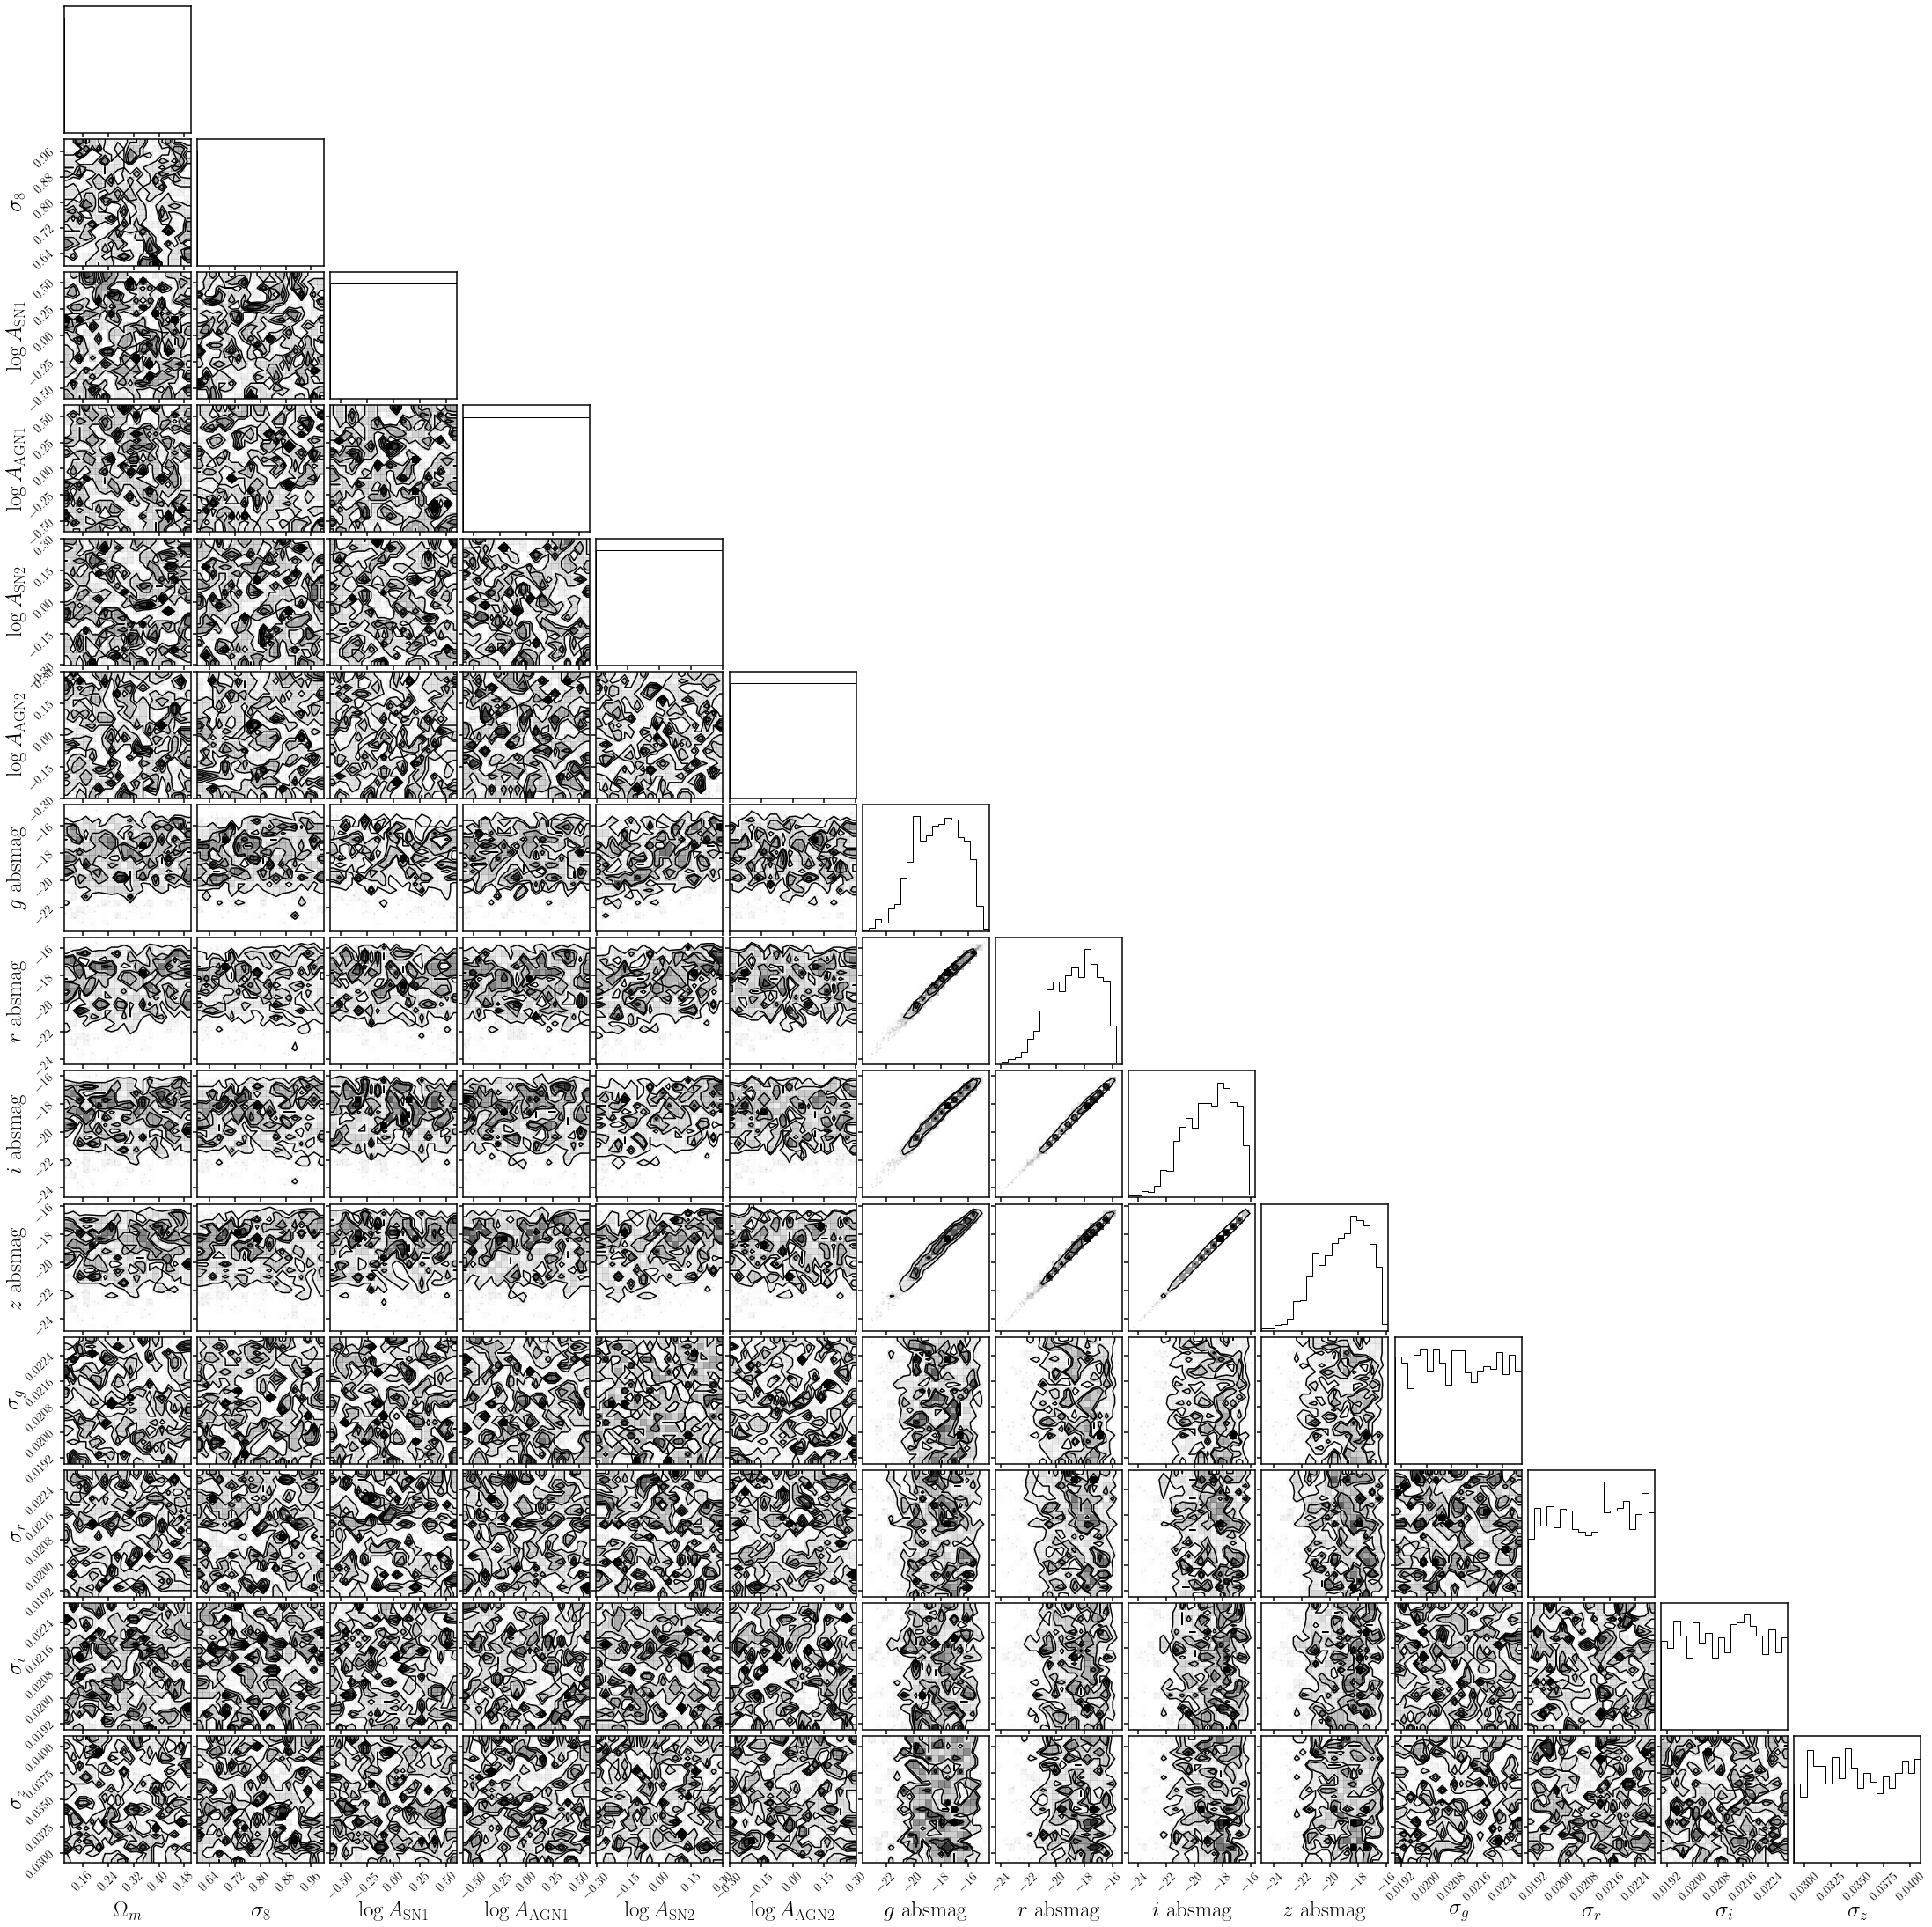

In [9]:
fig = DFM.corner(np.concatenate([data_omega, data_photo], axis=1)[::100], 
                 labels=[lbls[i] for i in icosmo + iobs]+[r'$\sigma_g$', r'$\sigma_r$', r'$\sigma_i$', r'$\sigma_z$'],
                 label_kwargs={'fontsize': 25})

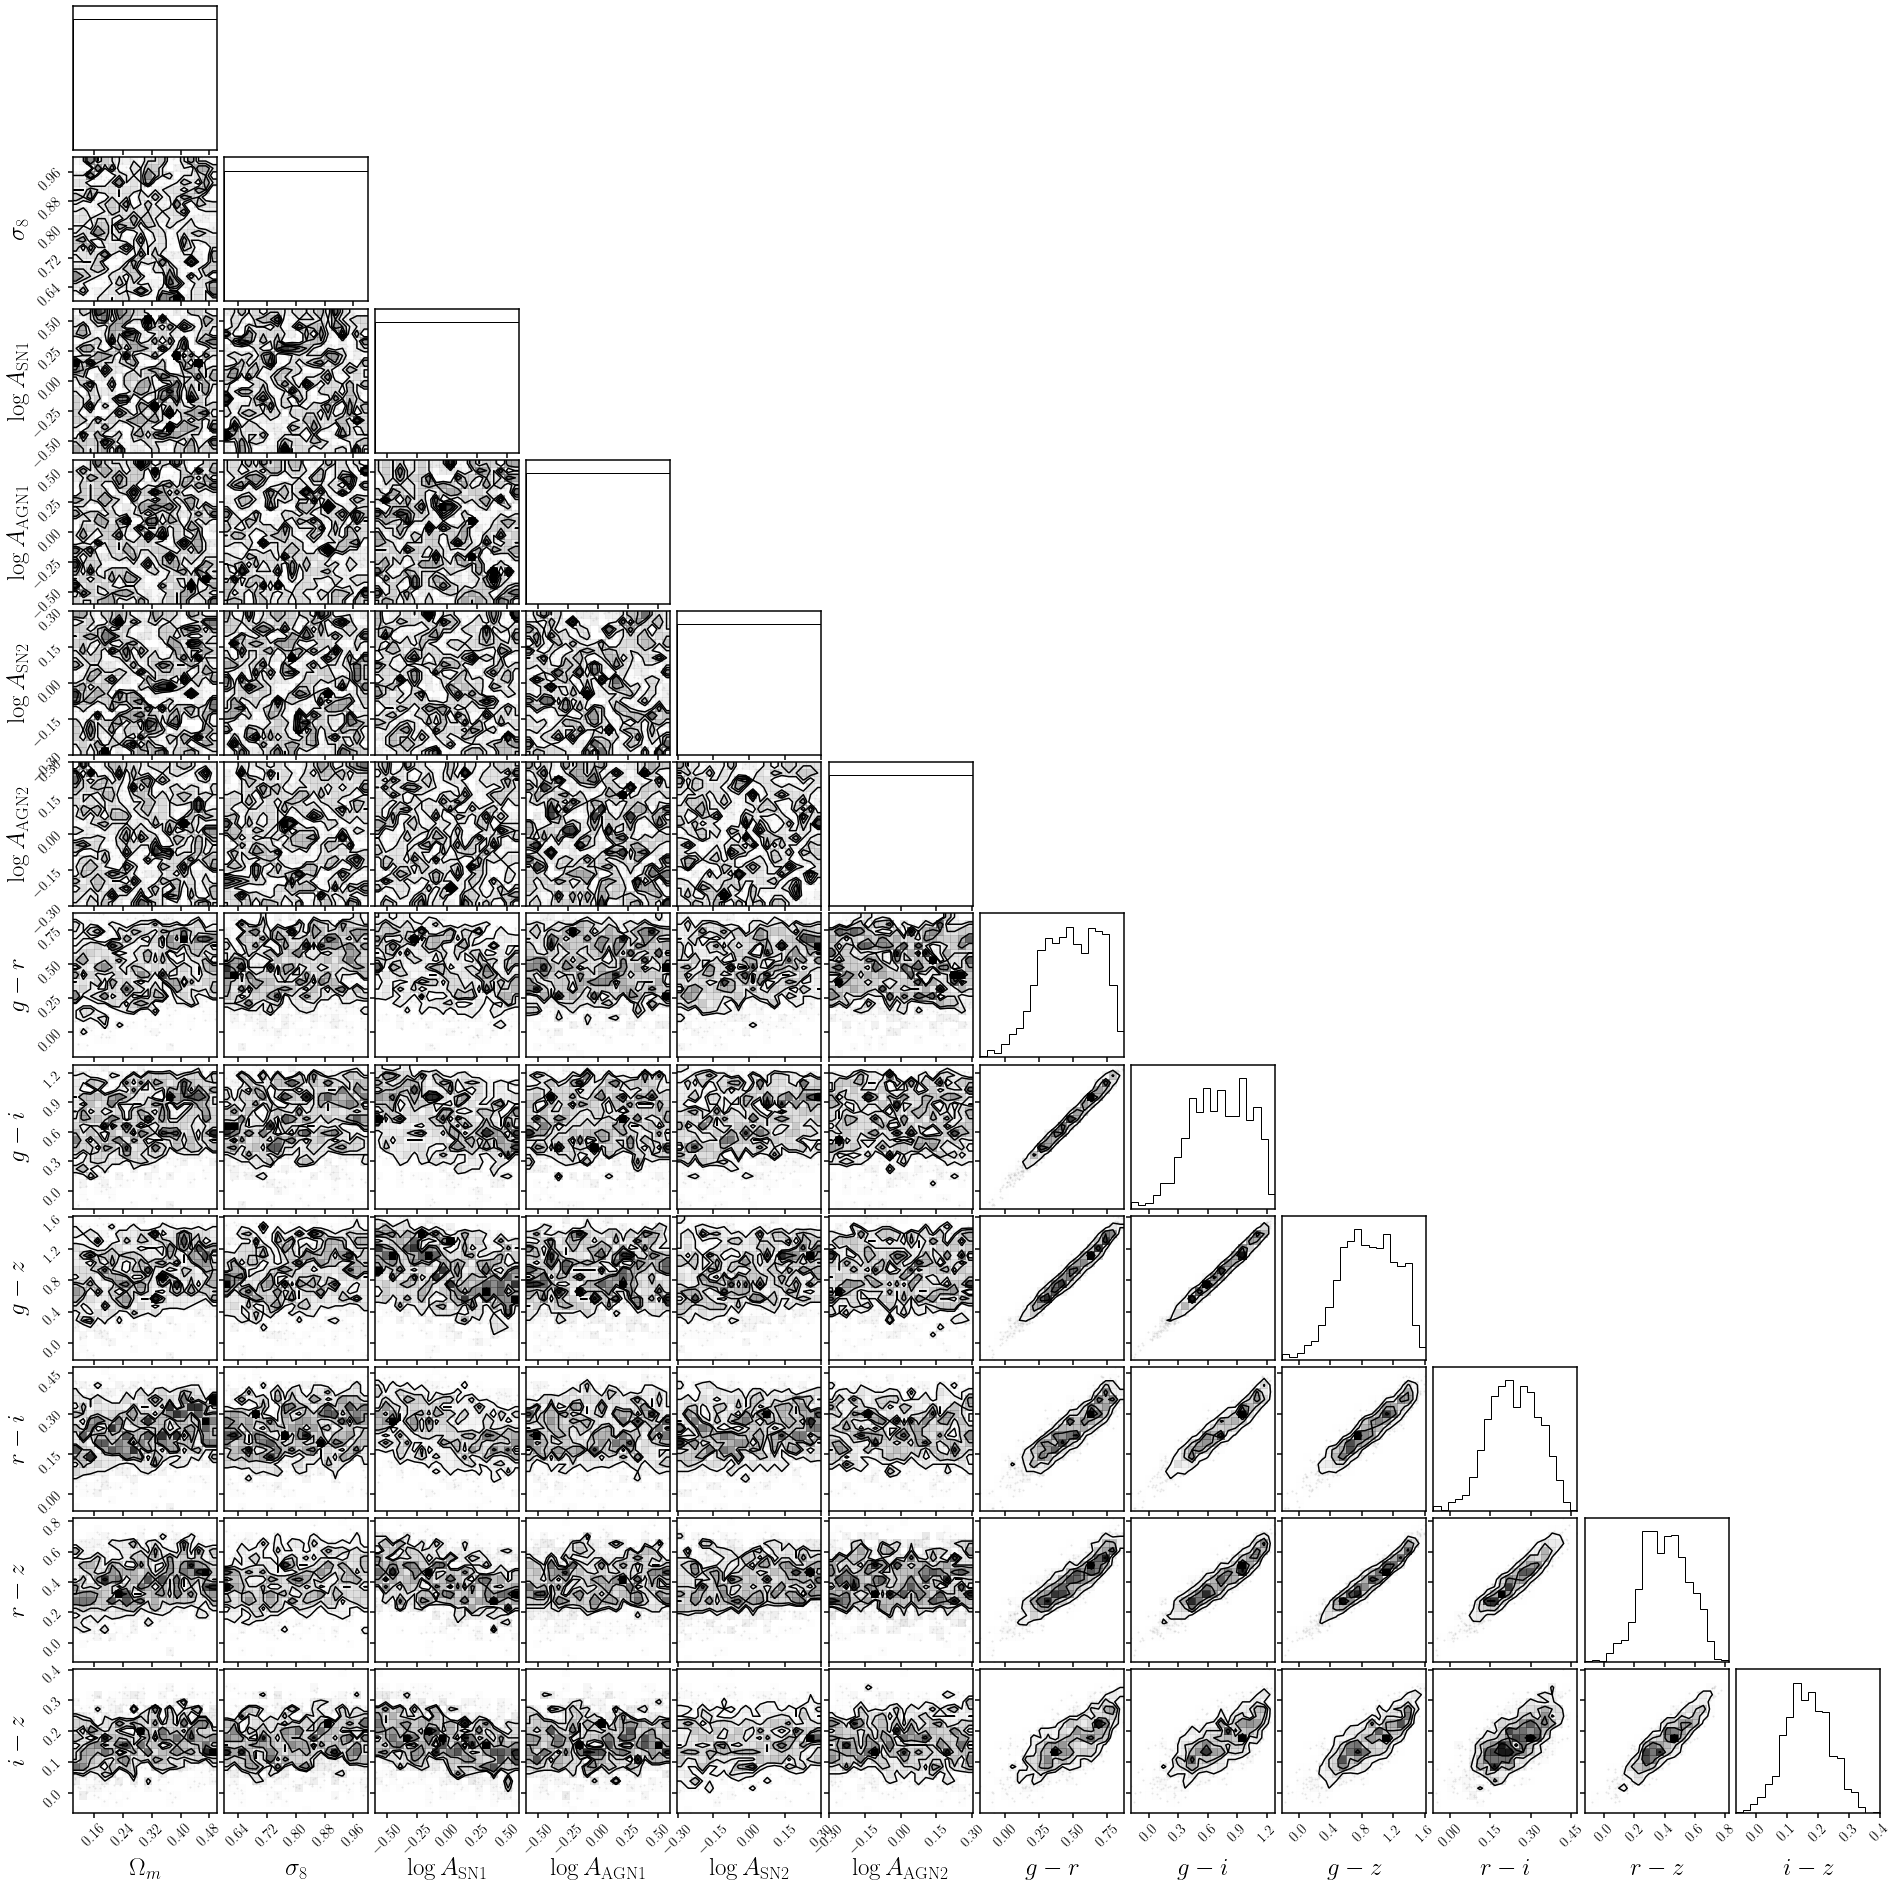

In [10]:
data_color = np.array([data_photo[:,0] - data_photo[:,1], 
                         data_photo[:,0] - data_photo[:,2], 
                         data_photo[:,0] - data_photo[:,3], 
                         data_photo[:,1] - data_photo[:,2], 
                         data_photo[:,1] - data_photo[:,3],
                         data_photo[:,2] - data_photo[:,3]]).T

fig = DFM.corner(np.concatenate([data_omega, data_color], axis=1)[::100], 
                 labels=[lbls[i] for i in icosmo]+[r'$g-r$', r'$g-i$', r'$g-z$', r'$r-i$', r'$r-z$', r'$i-z$'],
                 label_kwargs={'fontsize': 25})

# load trained $q_\phi(\Omega\,|\,X)$

In [11]:
# setup training data
ishuffle = np.arange(data_omega.shape[0])
np.random.shuffle(ishuffle)

N_train = int(0.9 * data_omega.shape[0])
x_train = data_photo[ishuffle[:N_train]]
y_train = data_omega[ishuffle[:N_train]]

N_test = data_omega.shape[0] - N_train
x_test = data_photo[ishuffle[N_train:]]
y_test = data_omega[ishuffle[N_train:]]

In [12]:
qphi = torch.load('/tigress/chhahn/cgpop/ndes/qphi.omega_x/qphi.omega_x.16.pt', 
                  map_location=torch.device(device))

In [46]:
# calculat ranks:
rank_thetas = []
for i in np.arange(x_test.shape[0])[(y_test[:,0] > 0.15) & (y_test[:,0] < 0.45)][:1000]:
    # sample posterior p(theta | x_test_i)
    y_prime = qphi.sample((10000,),
            x=torch.as_tensor(x_test[i].astype(np.float32)).to(device),
            show_progress_bars=False)
    y_prime = np.array(y_prime.detach().cpu())
    y_prime = y_prime[(y_prime[:,0] > 0.15) & (y_prime[:,0] < 0.45)]

    # calculate percentile score and rank
    rank_theta = []
    for itheta in range(y_test.shape[1]):
        rank_theta.append(np.mean(y_prime[:,itheta] < y_test[i,itheta]))
    rank_thetas.append(rank_theta)
rank_thetas = np.array(rank_thetas)

[]

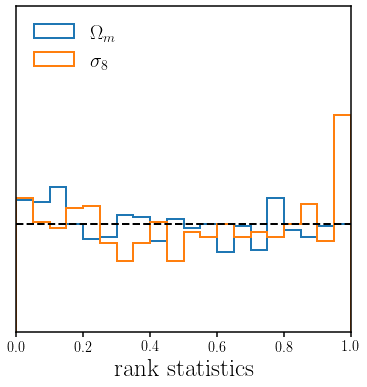

In [47]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
for i in range(2):#test_omega.shape[1]): 
    _ = sub.hist(np.array(rank_thetas)[:,i],
                 range=(0, 1), bins=20, density=True, histtype='step', 
                 linewidth=2, label=lbls[icosmo[i]])
sub.plot([0., 1.], [1., 1.], c='k', ls='--', linewidth=2)
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel('rank statistics', fontsize=25)
sub.set_xlim(0., 1.)
sub.set_ylim(0., 3)
#sub.set_ylim(0., 5e2)
sub.set_yticks([])

# lets checkout the distribution for a few NSA galaxies

In [13]:
import astropy.table as aTable

nsa = aTable.Table.read('/tigress/chhahn/cgpop/nsa_v0_1_2.fits')

In [14]:
absmag_nsa = np.array(nsa['ABSMAG'].data)[:,3:] # g, r, i, z
ivar_absmag_nsa = np.array(nsa['AMIVAR'].data)[:,3:]

colors_nsa = np.array([absmag_nsa[:,0] - absmag_nsa[:,1], 
                         absmag_nsa[:,0] - absmag_nsa[:,2], 
                         absmag_nsa[:,0] - absmag_nsa[:,3], 
                         absmag_nsa[:,1] - absmag_nsa[:,2], 
                         absmag_nsa[:,1] - absmag_nsa[:,3],
                         absmag_nsa[:,2] - absmag_nsa[:,3]]).T

In [34]:
# cuts on absmag uncertainties
cuts = ((nsa['Z'] < 0.05) & 
        np.all((ivar_absmag_nsa[:,:-1]**-0.5 > 0.02) & (ivar_absmag_nsa[:,:-1]**-0.5 < 0.022), axis=1) & 
        (ivar_absmag_nsa[:,-1]**-0.5 > 0.03) & (ivar_absmag_nsa[:,-1]**-0.5 < 0.04))
# cuts on absmag 
for i in range(4): 
    cuts = cuts & (absmag_nsa[:,i] < -18) & (absmag_nsa[:,i] > -22.)
# cuts on color 
cuts = cuts & (colors_nsa[:,0] > 0.264) & (colors_nsa[:,0] < 0.687)
cuts = cuts & (colors_nsa[:,1] > 0.423) & (colors_nsa[:,1] < 1.009)
cuts = cuts & (colors_nsa[:,2] > 0.538) & (colors_nsa[:,2] < 1.231)
cuts = cuts & (colors_nsa[:,3] > 0.151) & (colors_nsa[:,3] < 0.329)
cuts = cuts & (colors_nsa[:,4] > 0.263) & (colors_nsa[:,4] < 0.557)
cuts = cuts & (colors_nsa[:,5] > 0.097) & (colors_nsa[:,5] < 0.241)

print(np.sum(cuts))

Xs = np.concatenate([absmag_nsa[cuts], ivar_absmag_nsa[cuts]**-0.5], axis=1)

14736


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.


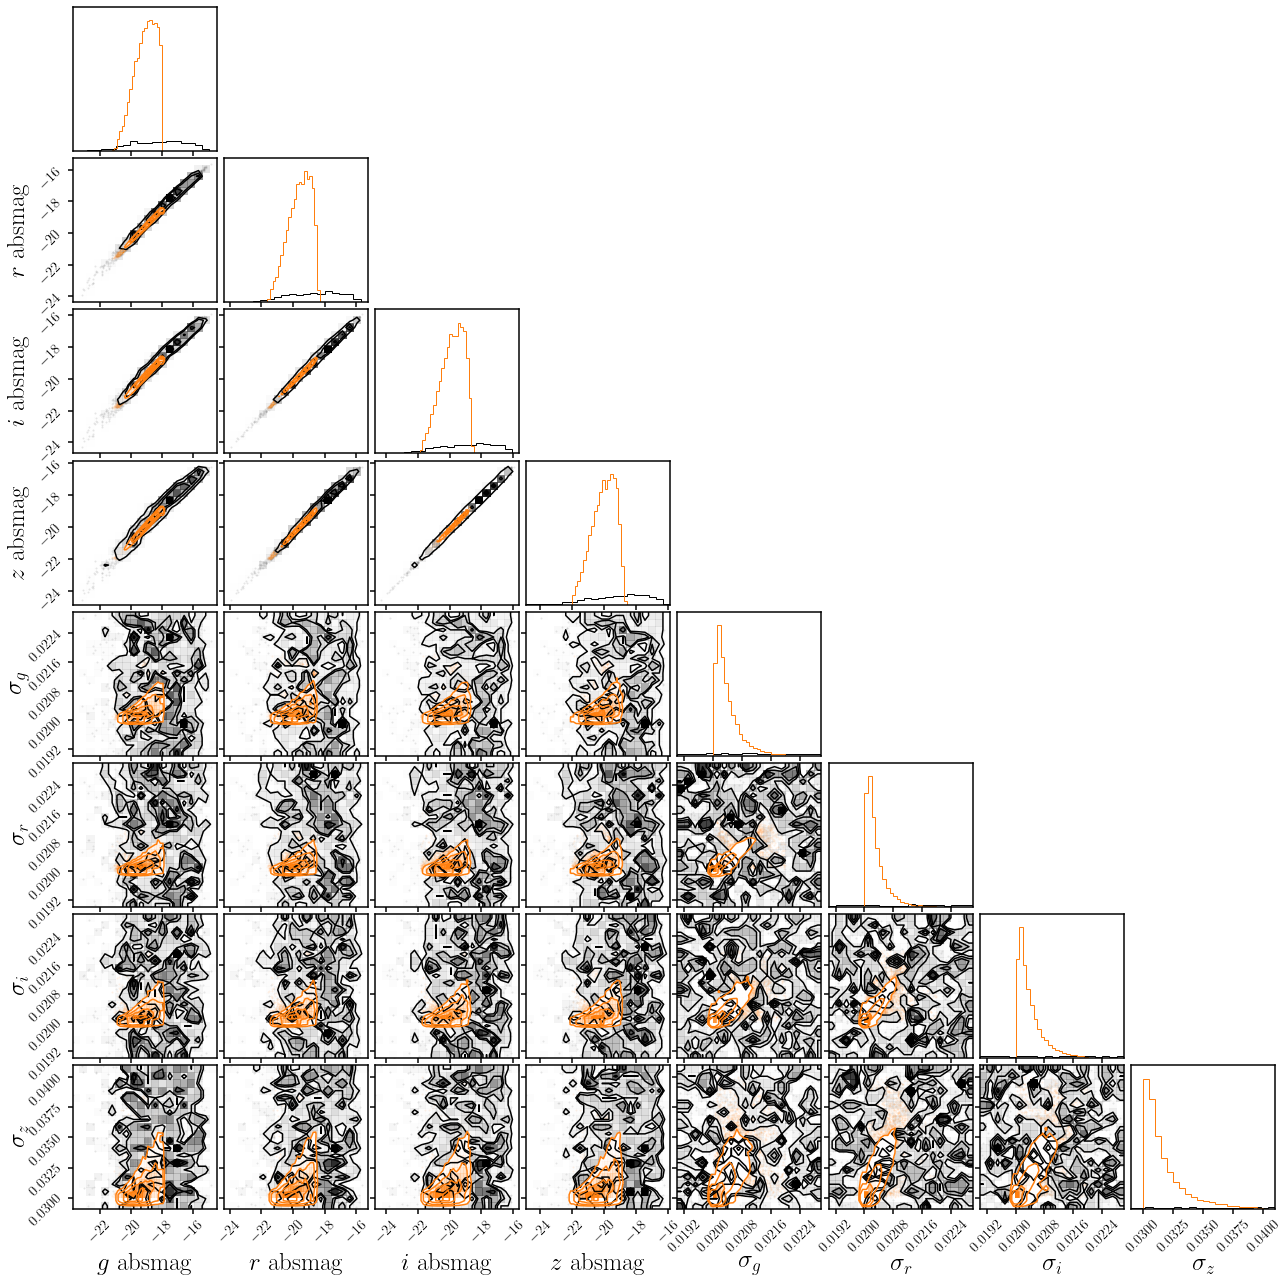

In [35]:
fig = DFM.corner(data_photo[::100], color='k',
                 labels=[lbls[i] for i in iobs]+[r'$\sigma_g$', r'$\sigma_r$', r'$\sigma_i$', r'$\sigma_z$'],
                 label_kwargs={'fontsize': 25})
_ = DFM.corner(Xs, color='C1', 
               labels=[lbls[i] for i in iobs]+[r'$\sigma_g$', r'$\sigma_r$', r'$\sigma_i$', r'$\sigma_z$'],
               label_kwargs={'fontsize': 25}, fig=fig)

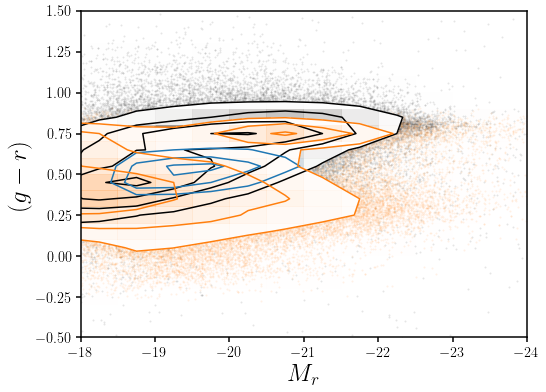

In [36]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

DFM.hist2d(absmag_nsa[:,1], absmag_nsa[:,0] - absmag_nsa[:,1], range=[(-24, -14), (-0.5, 1.5)], color='k', ax=sub)
DFM.hist2d(Xs[:,1], Xs[:,0] - Xs[:,1], range=[(-24, -14), (-0.5, 1.5)], color='C0', ax=sub)
DFM.hist2d(data_photo[:,1], data_photo[:,0] - data_photo[:,1], range=[(-24, -14), (-0.5, 1.5)], color='C1', ax=sub)
#sub.scatter(absmag_nsa[:,1], absmag_nsa[:,0] - absmag_nsa[:,1], c='k', s=0.1)
#sub.scatter(data_photo[:,1], data_photo[:,0] - data_photo[:,1], c='C0', s=0.1)

sub.set_xlabel('$M_r$', fontsize=25)
sub.set_xlim(-18, -24)
sub.set_ylabel('$(g-r)$', fontsize=25)
sub.set_ylim(-0.5, 1.5)
plt.show()

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/corner/core.py:675: UserWarning: The following kwargs were not used by contour: 'linestyle'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)


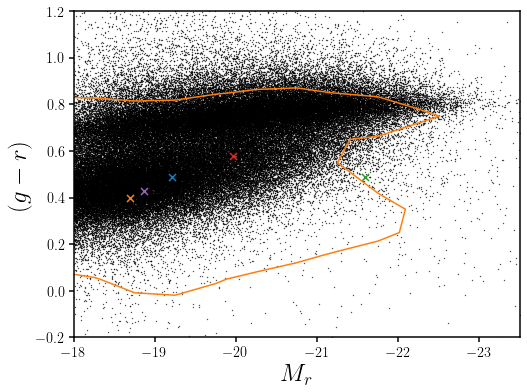

In [39]:
_range = [(0.15, 0.45), (0.65, 0.95), 
         (np.log10(0.25), np.log10(4.0)), (np.log10(0.25), np.log10(4.0)), 
         (np.log10(0.5), np.log10(2.0)), (np.log10(0.5), np.log10(2.0))]

igals = np.random.choice(np.arange(Xs.shape[0]), replace=False, size=5)

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/corner/core.py:675: UserWarning: The following kwargs were not used by contour: 'linestyle'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)


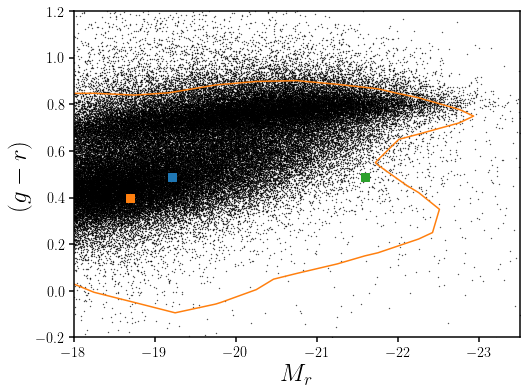

In [45]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.scatter(absmag_nsa[:,1][nsa['Z'] < 0.05], (absmag_nsa[:,0] - absmag_nsa[:,1])[nsa['Z'] < 0.05], color='k', s=0.1)
#DFM.hist2d(Xs[:,1], Xs[:,0] - Xs[:,1], range=[(-24, -14), (-0.5, 1.5)], color='k', ax=sub)
DFM.hist2d(data_photo[:,1], data_photo[:,0] - data_photo[:,1], 
           range=[(-24, -14), (-0.5, 1.5)], levels=[0.95], contour_kwargs={'linestyle':'--'}, 
           plot_density=False, plot_datapoints=False, no_fill_contours=True, fill_contours=False, 
           color='C1', ax=sub)

for _i, ii in enumerate(igals[:3]): 
    sub.scatter(Xs[ii, 1], Xs[ii,0] - Xs[ii,1], c='C%i' % _i, s=50, marker='s')

sub.set_xlabel('$M_r$', fontsize=25)
sub.set_xlim(-18, -23.5)
sub.set_ylabel('$(g-r)$', fontsize=25)
sub.set_ylim(-0.2, 1.2)
plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

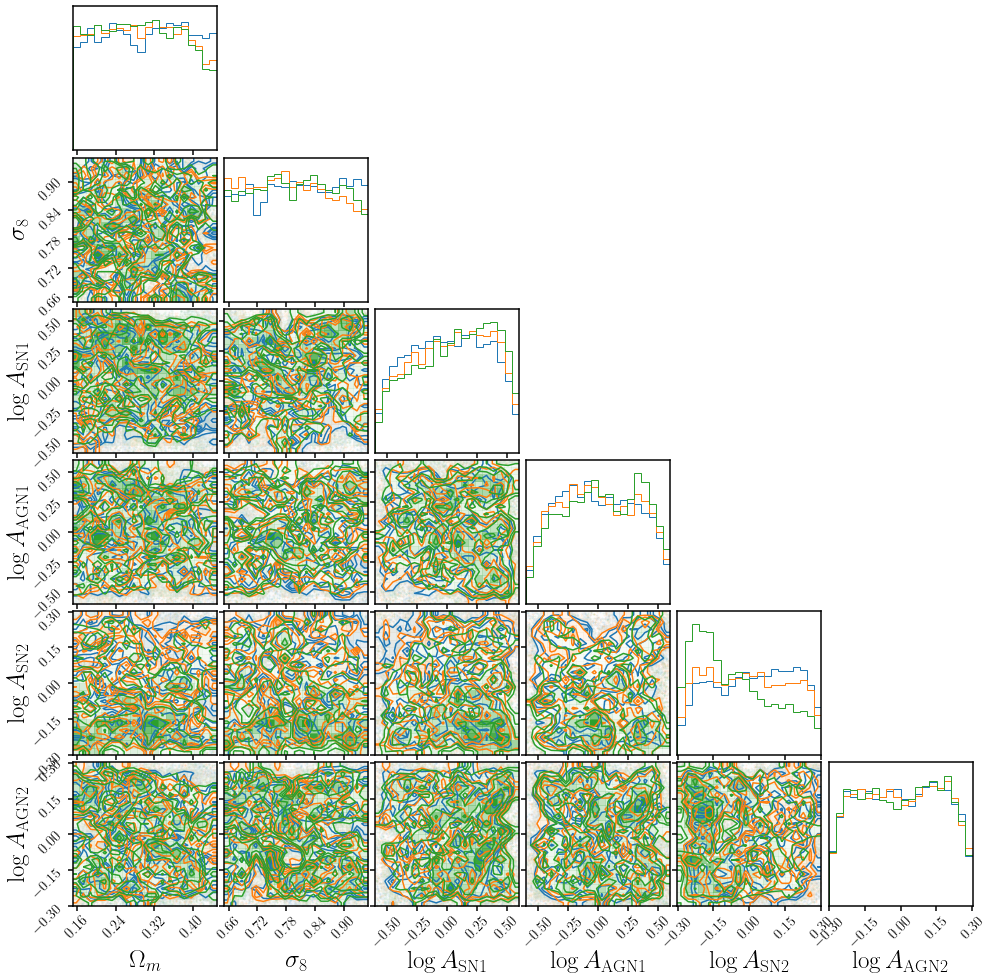

In [44]:
for _i, ii in enumerate(igals[:3]): 
    theta_prime = qphi.sample((10000,), 
                          x=torch.tensor(Xs[ii]).to(device))
    if ii == igals[0]: 
        fig = DFM.corner(np.array(theta_prime.cpu()), range=_range, 
                     hist_kwargs={'density': True}, color='C%i' % _i, labels=[lbls[i] for i in icosmo], label_kwargs={'fontsize': 25})
    else: 
        _ = DFM.corner(np.array(theta_prime.cpu()), range=_range, 
                     hist_kwargs={'density': True}, color='C%i' % _i, labels=[lbls[i] for i in icosmo], label_kwargs={'fontsize': 25}, fig=fig)

